# Single view metrology

In [13]:
import cv2
import numpy as np

import cv2
import numpy as np
import matplotlib.pyplot as plt

data_dir = "."

def plot_img(img_name):
    image_path = f"{data_dir}/{img_name}"
    plt.imshow(cv2.imread(image_path)[:, :, ::-1])
    plt.axis("off")

(-0.5, 959.5, 1279.5, -0.5)

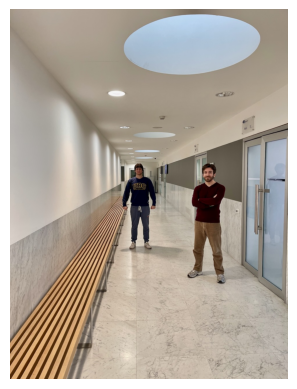

In [14]:
img = cv2.imread(f"{data_dir}/draft.jpeg")[:, :, ::-1]

plt.imshow(img)
plt.axis('off')

/var/folders/jt/lhtzzpdd2vs1b862wm2r6ynm0000gn/T/ipykernel_35070/944668613.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  points = plt.ginput(0, timeout=0)


KeyboardInterrupt: 

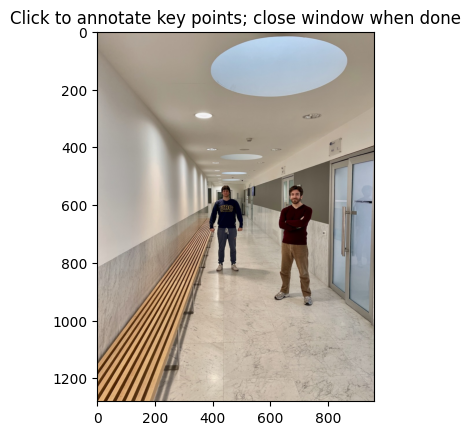

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

image_path = "draft.jpeg"

class SimpleMetrologyAnnotator:
    def __init__(self, image_path):
        """Initialize with an image path"""
        self.img = cv2.imread(image_path)
        if self.img is None:
            raise ValueError(f"Could not load image from {image_path}")
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        
        # Store points and lines
        self.points = []
        self.lines = []
        self.current_line = []
        
        # Keep track of point types
        self.point_types = []  # 'parallel', 'reference', 'measure'
        self.current_type = 'parallel'
        
        # Colors for different point types
        self.colors = {
            'parallel': 'red',
            'reference': 'green',
            'measure': 'blue'
        }
        
        # Setup the figure
        self.fig, self.ax = plt.subplots(figsize=(12, 10))
        plt.subplots_adjust(bottom=0.15)
        self.ax.imshow(self.img)
        self.ax.set_title(f"Annotation Mode: {self.current_type} lines")
        
        # Add buttons
        self.add_buttons()
        
        # Status message
        self.status_text = self.ax.text(
            0.5, 0.01, "Click to add points", 
            transform=self.fig.transFigure,
            horizontalalignment='center',
            color='black', fontsize=12
        )
        
        # Connect to mouse events
        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.cid_key = self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
    
    def add_buttons(self):
        """Add UI buttons"""
        # Type selection buttons
        ax_parallel = plt.axes([0.1, 0.05, 0.2, 0.05])
        self.btn_parallel = Button(ax_parallel, 'Parallel Lines')
        self.btn_parallel.on_clicked(lambda event: self.set_type('parallel'))
        
        ax_reference = plt.axes([0.35, 0.05, 0.2, 0.05])
        self.btn_reference = Button(ax_reference, 'Reference')
        self.btn_reference.on_clicked(lambda event: self.set_type('reference'))
        
        ax_measure = plt.axes([0.6, 0.05, 0.2, 0.05])
        self.btn_measure = Button(ax_measure, 'Measure')
        self.btn_measure.on_clicked(lambda event: self.set_type('measure'))
        
        # Save button
        ax_save = plt.axes([0.85, 0.05, 0.1, 0.05])
        self.btn_save = Button(ax_save, 'Save')
        self.btn_save.on_clicked(self.save_annotations)
    
    def set_type(self, point_type):
        """Set the current point type"""
        self.current_type = point_type
        self.ax.set_title(f"Annotation Mode: {self.current_type} lines")
        self.status_text.set_text(f"Mode: {self.current_type}. Click to add points.")
        self.fig.canvas.draw_idle()
    
    def on_click(self, event):
        """Handle mouse clicks"""
        if event.inaxes != self.ax:
            return
        
        x, y = event.xdata, event.ydata
        
        # Add point to the list
        self.points.append((x, y))
        self.point_types.append(self.current_type)
        
        # Plot the point
        self.ax.plot(x, y, 'o', color=self.colors[self.current_type], markersize=8)
        
        # Add label
        self.ax.text(x + 10, y + 10, f"{len(self.points)-1}", 
                   fontsize=12, color=self.colors[self.current_type])
        
        # If we're collecting a line, add to current line
        self.current_line.append((x, y))
        
        # If we have 2 points, we have a line
        if len(self.current_line) == 2:
            x1, y1 = self.current_line[0]
            x2, y2 = self.current_line[1]
            
            # Draw the line
            self.ax.plot([x1, x2], [y1, y2], '-', color=self.colors[self.current_type], linewidth=2)
            
            # Save the line
            self.lines.append((self.current_line[0], self.current_line[1], self.current_type))
            
            # Reset current line
            self.current_line = []
        
        self.fig.canvas.draw_idle()
    
    def on_key_press(self, event):
        """Handle key presses"""
        if event.key == 'escape':
            # Cancel current line if escape is pressed
            self.current_line = []
            self.status_text.set_text("Current line canceled. Click to start a new line.")
            self.fig.canvas.draw_idle()
        elif event.key == 'q':
            plt.close(self.fig)
    
    def save_annotations(self, event):
        """Save annotations to file"""
        # Create structured data
        annotations = {
            'points': self.points,
            'point_types': self.point_types,
            'lines': self.lines
        }
        
        # Save as NumPy file
        np.save('simple_metrology_annotations.npy', annotations)
        
        # Also save as text for easier viewing
        with open('simple_metrology_annotations.txt', 'w') as f:
            f.write("# Simple Metrology Annotations\n\n")
            
            # Save points
            f.write("## Points\n")
            for i, ((x, y), point_type) in enumerate(zip(self.points, self.point_types)):
                f.write(f"Point {i}: ({x:.2f}, {y:.2f}) - {point_type}\n")
            
            # Save lines
            f.write("\n## Lines\n")
            for i, ((x1, y1), (x2, y2), line_type) in enumerate(self.lines):
                f.write(f"Line {i}: ({x1:.2f}, {y1:.2f}) to ({x2:.2f}, {y2:.2f}) - {line_type}\n")
        
        self.status_text.set_text("Annotations saved to simple_metrology_annotations.npy and .txt")
        self.fig.canvas.draw_idle()
    
    def run(self):
        """Run the annotation tool"""
        plt.show()
        
        return {
            'points': self.points,
            'point_types': self.point_types,
            'lines': self.lines
        }


def process_annotations(annotations):
    """Process the annotations for single view metrology"""
    points = annotations['points']
    point_types = annotations['point_types']
    lines = annotations['lines']
    
    # Extract parallel lines
    parallel_lines = [line for line in lines if line[2] == 'parallel']
    
    # Group parallel lines into pairs
    parallel_pairs = []
    for i in range(0, len(parallel_lines), 2):
        if i+1 < len(parallel_lines):
            pair = (parallel_lines[i], parallel_lines[i+1])
            parallel_pairs.append(pair)
    
    # Compute vanishing points from parallel line pairs
    vanishing_points = []
    for (line1_start, line1_end, _), (line2_start, line2_end, _) in parallel_pairs:
        # Convert to homogeneous coordinates
        p1 = np.array([line1_start[0], line1_start[1], 1])
        p2 = np.array([line1_end[0], line1_end[1], 1])
        p3 = np.array([line2_start[0], line2_start[1], 1])
        p4 = np.array([line2_end[0], line2_end[1], 1])
        
        # Compute lines in homogeneous coordinates
        line1 = np.cross(p1, p2)
        line2 = np.cross(p3, p4)
        
        # Compute vanishing point as line intersection
        v = np.cross(line1, line2)
        
        # Normalize
        if v[2] != 0:
            v = v / v[2]
        
        vanishing_points.append(v)
    
    return {
        'original_annotations': annotations,
        'vanishing_points': vanishing_points
    }


def main():
    import argparse
    parser = argparse.ArgumentParser(description='Simple Metrology Annotation Tool')
    parser.add_argument('image_path', help='Path to the image file')
    args = parser.parse_args()
    
    annotator = SimpleMetrologyAnnotator(args.image_path)
    annotations = annotator.run()
    
    # Process annotations
    results = process_annotations(annotations)
    
    print("Annotation complete!")
    print(f"Found {len(results['vanishing_points'])} vanishing points")
    
    return results


if __name__ == "__main__":
    results = main()